**Install Packages**

In [3]:
! pip install mediapipe
! pip install cv2-utils

     |████████████████████████████████| 32.8 MB 1.2 MB/s 
  Created wheel for cv2-utils: filename=cv2_utils-0.2.0-py3-none-any.whl size=9094 sha256=a067ddc78dfdcb2d1f1ace17be728c38cbe92bd1c52aed38bee90ccf06420ace
  Stored in directory: /root/.cache/pip/wheels/03/98/e7/03ac2b63db985395009221654671cd9f5db5f61ef88f0fecfa
Successfully built cv2-utils


**Mount google drive**

Need access to dataset stored in drive 

In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


**Test to confirm**

Show image to confirm drive properly mounted and software is able to read images 

(1024, 1024, 3)


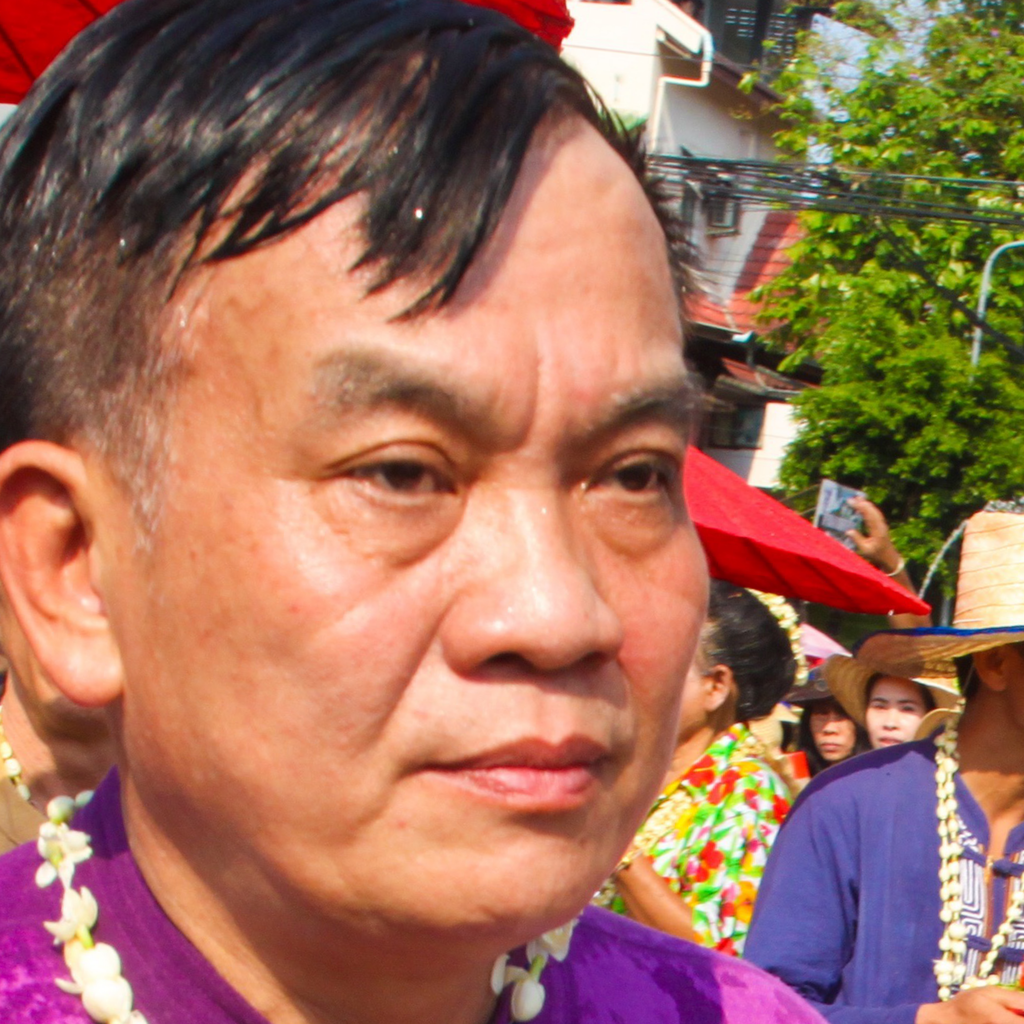

In [5]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
#test
img = cv2.imread("/content/gdrive/MyDrive/final_project/images/sample/01000.jpg")
print(img.shape)
cv2_imshow(img)

**Functions**

Functions adapted from https://medium.com/@asadullah92c/eyes-blink-detector-and-counter-mediapipe-a66254eb002c to compute ratio between eye key points  

**Landmarks Detection:** Returns the mesh coordinates for Mediapipe's facemesh 

**Euclaidean Distance:** Returns the distance of cartesian coordinates for the vertical and horizontal 

**Blink Ratio:** Determine and return the ratio of each respective eye

In [6]:
# Blinking Ratio
# Euclaidean distance
def landmarksDetection(img, results, draw=False):
    img_height, img_width= img.shape[:2]
    # list[(x,y), (x,y)....]
    mesh_coord = [(int(point.x * img_width), int(point.y * img_height)) for point in results.multi_face_landmarks[0].landmark]

    if draw :
        [cv2.circle(img, p, 2, (0,255,0), -1) for p in mesh_coord]

    # returning the list of tuples for each landmark 
    return mesh_coord

def euclaideanDistance(point, point1):
    x, y = point
    x1, y1 = point1
    distance = math.sqrt((x1 - x)**2 + (y1 - y)**2)
    return distance
# indicies = [right, left up, down]

def blinkRatio(landmarks, indices):
    # Right eyes 
    # horizontal line 
    rh_right = landmarks[indices[0]]
    rh_left = landmarks[indices[1]]
    # vertical line 
    rv_top = landmarks[indices[2]]
    rv_bottom = landmarks[indices[3]]
    # Finding Distance Right Eye
    rhDistance = euclaideanDistance(rh_right, rh_left)
    rvDistance = euclaideanDistance(rv_top, rv_bottom)
    # smaller ratio --> eyes are more closed
    # bigger ratio --> eyes are more open
    Ratio = rvDistance/rhDistance
    return Ratio

def drawlines(img, landmarks, indices): 
  # draw lines on right eyes 
  # cv.line(img, rh_right, rh_left, utils.GREEN, 2)
  # cv.line(img, rv_top, rv_bottom, utils.WHITE, 2)
  rh_right = landmarks[indices[1]]
  rh_left = landmarks[indices[0]]
  rv_top = landmarks[indices[2]]
  rv_bottom = landmarks[indices[3]]
  green = (0, 255, 0)
  white = (255, 255, 255)
  cv2.line(img, (rh_right[0], rh_right[1]), (rh_left[0], rh_left[1]), green, 2)
  #print('img size: ', img.shape)
  #print('right:', tuple(rh_right))
  
  #print(tuple(rh_left))
  cv2.line(img, tuple(rv_top), tuple(rv_bottom), white, 2)
  #print(tuple(rv_top))

  return img

**Mediapipe Implementation**

Code modified from Nerea Aranjuelo and mediapipe function implementation

The following code will detect faces in an image and fit a face mesh, then crop out eye images and save them to drive. 

In [7]:
import cv2
import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2
import math
import glob
import os
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh


def __normalized_to_pixel_coordinates(
        normalized_x: float, normalized_y: float, image_width: int,
        image_height: int):
    """Converts normalized value pair to pixel coordinates."""

    # Checks if the float value is between 0 and 1.
    def is_valid_normalized_value(value: float) -> bool:
        return (value > 0 or math.isclose(0, value)) and \
               (value < 1 or math.isclose(1, value))

    if not (is_valid_normalized_value(normalized_x) and
            is_valid_normalized_value(normalized_y)):
        # TDO: Draw coordinates even if it's outside of the image bounds.
        return None
    x_px = min(math.floor(normalized_x * image_width), image_width - 1)
    y_px = min(math.floor(normalized_y * image_height), image_height - 1)
    return [x_px, y_px]

def __get_eye_mouth_landmarks(face_landmarks: landmark_pb2.NormalizedLandmarkList,
                              image_cols: int, image_rows: int):
    r_eye_landmarks = []
    l_eye_landmarks = []
    mouth_landmarks = []

    for idx, landmark in enumerate(face_landmarks.landmark):
        if ((landmark.HasField('visibility') and
             landmark.visibility < 0.5) or
                (landmark.HasField('presence') and
                 landmark.presence < 0.5)):
          # Points on the face mesh for right eye
            if idx in (7, 33, 133, 144, 145, 153, 154, 155, 157, 158, \
                       159, 160, 161, 163, 173, 246, 469, 470, 471, 472):
                r_eye_landmarks.append((-1, -1))
           # Points on the face mesh for left eye
            elif idx in (249, 263, 362, 373, 374, 380, 381, 382, 384, 385, \
                         386, 387, 388, 390, 398, 466, 474, 475, 476, 477):
                l_eye_landmarks.append((-1, -1))
            elif idx in (78, 308, 17, 0):
                mouth_landmarks.append((-1, -1))
            continue

        landmark_px = __normalized_to_pixel_coordinates(
            normalized_x=landmark.x, normalized_y=landmark.y,
            image_width=image_cols, image_height=image_rows)
        if not landmark_px:
            continue

        if idx in (7, 33, 133, 144, 145, 153, 154, 155, 157, 158, \
                   159, 160, 161, 163, 173, 246, 469, 470, 471, 472):
          #[right: 33, left: 133, top: 159, bottom: 145]
          #[right: 1, left: 2, top: 10, bottom: 4]
            r_eye_landmarks.append(landmark_px)
        elif idx in (249, 263, 362, 373, 374, 380, 381, 382, 384, 385, \
                     386, 387, 388, 390, 398, 466, 474, 475, 476, 477):
          # [left: 362, 263, 386,374]
          # [2, 1, 10, 4]
            l_eye_landmarks.append(landmark_px)
        elif idx in (78, 308, 17, 0):
            mouth_landmarks.append(landmark_px)
    return l_eye_landmarks, r_eye_landmarks, mouth_landmarks

def __crops_eye_AFFNet(img, l_corner, r_corner, w, h):
    dX = abs(r_corner[0] - l_corner[0])

    desired_eye_x = 1.7*dX # we choose fixed size for the crop depending on eye coordinates
    eye_center_x = (r_corner[0] + l_corner[0])*0.5
    eye_center_y = (r_corner[1] + l_corner[1]) * 0.5
    l_corner_crop_x = max(0, int(eye_center_x - int(desired_eye_x*0.5)))
    r_corner_crop_x = min(w, int(eye_center_x + int(desired_eye_x * 0.5)))
    l_corner_crop_y = max(0, int(eye_center_y - int(desired_eye_x * 0.5)))
    r_corner_crop_y = min(h, int(eye_center_y + int(desired_eye_x * 0.5)))

    cropped_img = img[l_corner_crop_y:r_corner_crop_y, l_corner_crop_x: r_corner_crop_x]

    return cropped_img, [(l_corner_crop_x, l_corner_crop_y), (r_corner_crop_x, r_corner_crop_y)]

# For static images:
# TODO: Make a loop for the image files 
IMAGE_FILES = glob.glob("/content/gdrive/MyDrive/final_project/images/sample/*.jpg", recursive= True)
#images = [cv2.imread(file) for file in IMAGE_FILES]
print(IMAGE_FILES)
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
if __name__ == "__main__":
  right_indices_ratio = []
  left_indices_ratio = []
  indicies_right = [1,2,10,4]
  # [right: 362, 263, 386,374]
  indicies_left = [2,1,10,4]
  #[right: 33, left: 133, top: 159, bottom: 145]

  with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=10,
        min_detection_confidence=0.5) as face_mesh:
      for idx, file in enumerate(IMAGE_FILES):
        image = cv2.imread(file, 1)
        # Convert the BGR image to RGB before processing.
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        h,w,_ = image.shape
# Print and draw face mesh landmarks on the image.

        #if not results.multi_face_landmarks:
          #continue
        annotated_image = image.copy()

        for face_landmarks in results.multi_face_landmarks:
            # print('face_landmarks:', face_landmarks)
            mp_drawing.draw_landmarks(
                image = annotated_image,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=mp_drawing.DrawingSpec(thickness=1, circle_radius=1),
                connection_drawing_spec=mp_drawing.DrawingSpec(thickness=1, circle_radius=1))

        # Face meshed fitted, now crop eye regions:
        # have to figure this out it won't do multiple faces
            l_eye_landmarks, r_eye_landmarks, mouth_landmarks = \
                __get_eye_mouth_landmarks(
                    face_landmarks, w, h)
        # Get eye images
        # taking points based on width of eye
        l_eye_center = (
            int(0.5 * (l_eye_landmarks[1][0] + l_eye_landmarks[2][0]) + 0.5),
            int(0.5 * (l_eye_landmarks[1][1] + l_eye_landmarks[2][1]) + 0.5)
        )

        r_eye_center = (
            int(0.5 * (r_eye_landmarks[1][0] + r_eye_landmarks[2][0]) + 0.5),
            int(0.5 * (r_eye_landmarks[1][1] + r_eye_landmarks[2][1]) + 0.5)
        )
        l_eye_img, bb_leye = __crops_eye_AFFNet(
            image, l_eye_landmarks[1], l_eye_landmarks[2], w, h)
        r_eye_img, bb_reye = __crops_eye_AFFNet(
            image, r_eye_landmarks[1], r_eye_landmarks[2], w, h) 
           
        # compute ratio 
        # blinkRatio(landmarks, indices, left_indices):
        #print(results.multi_face_landmarks[0])
        blink_ratio_right = blinkRatio(r_eye_landmarks, indicies_right)
        right_indices_ratio.append(blink_ratio_right)
        image_r = drawlines(annotated_image, r_eye_landmarks, indicies_right)
        #plt.imshow(l_eye_img)
        #print(right_indices_ratio)
        blink_ratio_left = blinkRatio(l_eye_landmarks, indicies_left)
        left_indices_ratio.append(blink_ratio_left)
        image_lines = drawlines(image_r, l_eye_landmarks, indicies_left)
      
        path = "/content/gdrive/MyDrive/final_project/images/sample/"
        annotated_path = "/content/gdrive/MyDrive/final_project/images/sample/annotated_images/"
        l_eye_path = "/content/gdrive/MyDrive/final_project/images/sample/l_eye_images/"
        r_eye_path = "/content/gdrive/MyDrive/final_project/images/sample/r_eye_images/"

        
        filename = annotated_path+'/annotated_img_%d.jpg' %idx
        cv2.imwrite(filename, image_lines)
        #img = "/content/gdrive/MyDrive/final_project/images/sample/l_eye_images/test.jpg" 
        #image = cv2.imread(img)


        try:
          filename = l_eye_path +"/l_eye_img_%d_%f.jpg" % (idx, blink_ratio_left)
          #print(l_eye_img)
          cv2.imwrite(filename, l_eye_img) 
          
          #cv2.imwrite(Do+'leye.png', l_eye_img) 
        except:
          print('no left eye detected')

        try:
          filename = r_eye_path +"/r_eye_img_%d_%f.jpg" % (idx, blink_ratio_right)
          cv2.imwrite(filename, r_eye_img) 
          # #cv2.imwrite(Do+'reye.png', r_eye_img)
        except:
          print('no right eye detected')         

['/content/gdrive/MyDrive/final_project/images/sample/01001 (1).jpg', '/content/gdrive/MyDrive/final_project/images/sample/01002 (1).jpg', '/content/gdrive/MyDrive/final_project/images/sample/01003 (1).jpg', '/content/gdrive/MyDrive/final_project/images/sample/01004 (1).jpg', '/content/gdrive/MyDrive/final_project/images/sample/01005 (1).jpg', '/content/gdrive/MyDrive/final_project/images/sample/01006 (1).jpg', '/content/gdrive/MyDrive/final_project/images/sample/01007.jpg', '/content/gdrive/MyDrive/final_project/images/sample/01008.jpg', '/content/gdrive/MyDrive/final_project/images/sample/01009.jpg', '/content/gdrive/MyDrive/final_project/images/sample/01010.jpg', '/content/gdrive/MyDrive/final_project/images/sample/01011.jpg', '/content/gdrive/MyDrive/final_project/images/sample/01012.jpg', '/content/gdrive/MyDrive/final_project/images/sample/01013.jpg', '/content/gdrive/MyDrive/final_project/images/sample/01014.jpg', '/content/gdrive/MyDrive/final_project/images/sample/01015.jpg', 

For some inspiration, we checked out Iris Mediapipe:

 https://google.github.io/mediapipe/solutions/iris.html 


---



In [8]:
### In a loop below, for each eye image (L, R) we compute the ratio of height vs width and add it to a list. 
## Hardcore values for eyes open/shut/squinting 
#### Compare those three values and then classify images 

**Ratio Test:**

In [9]:
# Ratios
## print('List of right eye ratios: ', right_indices_ratio)  
## print('List of left eye ratios: ', left_indices_ratio) 

List of right eye ratios:  [0.3351468769481602, 0.36602963700674057, 0.26676795417390226, 0.240868951188526, 0.2549155731972524, 0.42087280796849175, 0.2575683664867139, 0.18648160693268165, 0.3367086050489711, 0.2985793855863203, 0.34547527221480095, 0.283361603810951, 0.3191366035119019, 0.28395801820666067, 0.36316923312953137, 0.29278792776035323, 0.3119365400152933, 0.24200421016141238, 0.40152628816625324, 0.4687008265178375, 0.2540853930732345, 0.32877443246785876, 0.2972008763575466, 0.2921529786302018, 0.27065492085176995, 0.2831213295631639, 0.3144424150326564, 0.31854414787389856, 0.32713128870315644, 0.2811523172080767, 0.3549526838876904, 0.28752236772445666, 0.3169449080253124, 0.26457635373568755, 0.28122413640501365, 0.37073555186267776, 0.3722078025630636, 0.26451409643354734, 0.3400858170952206, 0.25921412899814317, 0.2898293184943136, 0.2736687699217976, 0.3642778065796289, 0.291387104907621, 0.29225241029236315, 0.2904261440241621, 0.2901378482246392, 0.294244336026

**Threshold eye state detection** 

**FUCTIONS**

Determines if the eyes for each list are open or closed by returning a list of binary states. If returns a 0, then the eye is closed. If returns a 1, then the eye is open. Check out the sorted eye ratios as well. 

In [10]:
# Threshold number: can adjust/change 
ratios_right_sorted = np.unique(right_indices_ratio)
ratios_left_sorted = np.unique(left_indices_ratio)
#print(ratios_right_sorted)
#print(ratios_left_sorted)
def avgRatio(l_ratio, r_ratio): 
  avg = (l_ratio + r_ratio)/2 
  return avg

def eyeOpenOrClosed(ratio, closed, open): 
  ## still need to figure out numbers  
  if np.any(ratio > closed):  
    return 1
  if np.any(ratio <= closed): 
    return 0


**GROUND TRUTH LABELS** 

Compare predicted versus ground truth labels

Function returns the adjusted predicted list after each iteration of an image

In [11]:
import os 
from sklearn.metrics import f1_score
l_score=[]
r_score=[]
# Is there a better way to determine these thresholds? 

# right ratio
ground_truth = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

# For other dataset: 
#ground_truth = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

for i in range(2,51):
  bottom_r = len(ratios_right_sorted)//i
  thresh_b = ratios_right_sorted[:bottom_r]
  thresh_b_num = np.max(thresh_b)
  print(thresh_b_num)
  thresh_t = ratios_right_sorted[bottom_r:]
  thresh_t_num = np.max(thresh_t)
  #print(thresh_t)
  dir_list_r = os.listdir(r_eye_path)
  #(dir_list_r)
  dir_list_l = os.listdir(l_eye_path)
  #test 
  avg_ratio = []
  EAR_r = []
  EAR_l = []

  for i in range(len(ratios_right_sorted)): 
    EAR_r.append(eyeOpenOrClosed(right_indices_ratio[i], thresh_b_num, thresh_t_num))
  print("List of eyes open or closed (right eye): ", EAR_r)

  for i in range(len(ratios_left_sorted)): 
    EAR_l.append(eyeOpenOrClosed(left_indices_ratio[i], thresh_b_num, thresh_t_num))
  print("List of eyes open or closed (left eye): ", EAR_l)
  l_score.append(f1_score(EAR_l, ground_truth))
  r_score.append(f1_score(EAR_r, ground_truth))

0.2921529786302018
List of eyes open or closed (right eye):  [1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0]
List of eyes open or closed (left eye):  [0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1]
0.28122413640501365
List of eyes open or closed (right eye):  [1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]
List of eyes open or closed (left eye):  [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1]
0.27065492085176995
List of eyes open or closed (right eye):  [1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,

**Graph of Ground truth For Right and Left Eye Ratios**

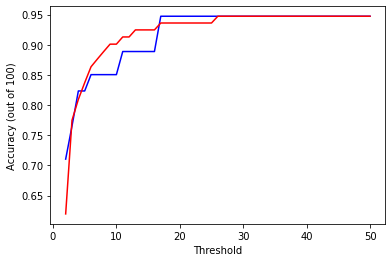

In [12]:
# Ground truth For Right and Left Eye Graph 
xs=np.arange(2,51,1)
plt.plot(xs,l_score, color = 'blue', label='left eye')
plt.plot(xs,r_score, color = 'red', label="right eye")
plt.xlabel('Threshold')
plt.ylabel('Accuracy (out of 100)')
plt.show()
# A more data driven way to determine the actual thresholds: 

**STATISTICAL ANALYSIS** 

In this part, we crated two tables in order to compare the eye ratios, whether the eyes are open or closed, and the ground truth. Remember, 0 = closed, 1 = open

In [13]:
# Tables for statistical analysis 
import pandas as pd 

#print('RIGHT EYE DATA')
d_r = {'Image Path': IMAGE_FILES,
     'Eye Ratio': right_indices_ratio, 
     'Open or Closed': EAR_r,
     'Ground Truth': ground_truth, 
     } 
df_r = pd.DataFrame(data = d_r)
print(df_r)
#print('\n')
#print('======================================================================================')
#print('\n')

#print('LEFT EYE DATA')
d_l = {'Image Path': IMAGE_FILES,
     'Eye Ratio': left_indices_ratio, 
     'Open or Closed': EAR_l,
     'Ground Truth': ground_truth, 
     } 
df_l = pd.DataFrame(data = d_l)
print(df_r)

from pathlib import Path  
filepath_l = Path('gdrive/MyDrive/images/left.csv')
filepath_r = Path('gdrive/MyDrive/images/right.csv')  
filepath_r.parent.mkdir(parents=True, exist_ok=True)  
df_l.to_csv(filepath_l) 
df_r.to_csv(filepath_r)


                                           Image Path  Eye Ratio  \
0   /content/gdrive/MyDrive/final_project/images/s...   0.335147   
1   /content/gdrive/MyDrive/final_project/images/s...   0.366030   
2   /content/gdrive/MyDrive/final_project/images/s...   0.266768   
3   /content/gdrive/MyDrive/final_project/images/s...   0.240869   
4   /content/gdrive/MyDrive/final_project/images/s...   0.254916   
5   /content/gdrive/MyDrive/final_project/images/s...   0.420873   
6   /content/gdrive/MyDrive/final_project/images/s...   0.257568   
7   /content/gdrive/MyDrive/final_project/images/s...   0.186482   
8   /content/gdrive/MyDrive/final_project/images/s...   0.336709   
9   /content/gdrive/MyDrive/final_project/images/s...   0.298579   
10  /content/gdrive/MyDrive/final_project/images/s...   0.345475   
11  /content/gdrive/MyDrive/final_project/images/s...   0.283362   
12  /content/gdrive/MyDrive/final_project/images/s...   0.319137   
13  /content/gdrive/MyDrive/final_project/images

**Independent Samples T Test**

Can find math functions for each function here: 

https://libguides.library.kent.edu/spss/independentttest 

Tutorial on how to use researchpy for a independent samples t-test: 

https://www.pythonfordatascience.org/independent-samples-t-test-python/

In [14]:
pip install researchpy

In [15]:
# Independent Samples T Test 
import scipy.stats as stats
l_eye_observations = len(left_indices_ratio)
r_eye_observations = len(right_indices_ratio)

degrees_of_freedom = l_eye_observations + r_eye_observations - 2
print('Degrees of freedom: ', degrees_of_freedom)

# assume alpha is 0.05, will be 0.025 for two-tailed test 
alpha = 0.05
two_tailed_test_prob_tail = alpha/2
t_critical = round(stats.t.ppf(two_tailed_test_prob_tail, degrees_of_freedom), 3)
print('critical value: ', t_critical)
# critical is actually +/- for two tailed test   

# Standard Error 
stats.ttest_ind(a= left_indices_ratio, b=right_indices_ratio, equal_var=False, nan_policy='omit')

# Means
mean_l_eye = np.mean(left_indices_ratio)
mean_r_eye = np.mean(right_indices_ratio)

# SD 
std_dev_l_eye = np.std(left_indices_ratio, ddof=1)
std_dev_r_eye = np.std(right_indices_ratio, ddof=1)

# SE 
standard_error = np.sqrt((std_dev_l_eye**2/l_eye_observations)+(std_dev_r_eye**2/r_eye_observations))
print('Standard error:', standard_error)

# t- value 
t_statistic = (mean_l_eye-mean_r_eye)/standard_error
print('t test value:', t_statistic)

if (t_critical < 0 and t_critical < t_statistic) or (t_statistic > 0 and t_statistic > t_critical):
  print('FAIL TO REJECT NULL HYPOTHESIS') 
else: 
  print('REJECT NULL HYPOTHESIS')

Degrees of freedom:  98
critical value:  -1.984
Standard error: 0.01133770339344467
t test value: 0.12925877481759646
FAIL TO REJECT NULL HYPOTHESIS


**Threshold Attempt #1:** Tried to implement a threshold equation to detect if the eyes were open, squinted, or closed, but only works if there is an equal distribution of such eye states. Disreguard, but you are welcome to check it out:

In [ ]:
# Threshold number: can adjust/change 
"""
ratios_right_sorted = np.unique(right_indices_ratio)
ratios_left_sorted = np.unique(left_indices_ratio)
print(ratios_right_sorted)
print(ratios_left_sorted)
np.unique(left_indices_ratio)
def avgRatio(l_ratio, r_ratio): 
  avg = (l_ratio + r_ratio)/2 
  return avg

def eyeOpenOrClosed(ratio, closed, squint, open): 
  ## still need to figure out numbers  
  yes = 'OPEN'
  maybe = 'SQUINT'
  no = 'CLOSED'
  if np.any(ratio >= open):  
    return yes
  elif np.any(ratio > closed) and np.any(ratio <= squint): 
    return maybe 
  else: 
    return no

#test 
avg_ratio = []
EAR = []
for i in range(len(left_indices_ratio)): 
  avg_ratio.append(avgRatio(left_indices_ratio[i], right_indices_ratio[i]))
print("List of average ratios for each eye: ", avg_ratio)
avg_ratio_sorted = np.unique(avg_ratio)
#print(avg_ratio[10])
third = len(avg_ratio_sorted)//3
thresh_b = avg_ratio_sorted[:third]
thresh_b_num = np.max(thresh_b)
print(thresh_b_num)
thresh_m = avg_ratio_sorted[third:(third*2)]
thresh_m_num = np.max(thresh_m)
#print(thresh_m)
thresh_t = avg_ratio_sorted[(third*2):]
thresh_t_num = np.max(thresh_t)
#print(thresh_t)

for i in range(len(avg_ratio)): 
  EAR.append(eyeOpenOrClosed(avg_ratio[i], thresh_b, thresh_m, thresh_t))
print("List of eyes open or closed: ", EAR)
"""